In [ ]:
!pip install python-terrier

     |████████████████████████████████| 97 kB 2.9 MB/s 
     |████████████████████████████████| 1.1 MB 32.6 MB/s 
     |████████████████████████████████| 69 kB 6.9 MB/s 
     |████████████████████████████████| 297 kB 60.4 MB/s 
     |████████████████████████████████| 41 kB 236 kB/s 
     |████████████████████████████████| 6.4 MB 46.4 MB/s 
     |████████████████████████████████| 72 kB 1.4 MB/s 
     |████████████████████████████████| 596 kB 68.5 MB/s 
     |████████████████████████████████| 294 kB 63.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 126 kB 47.1 MB/s 
     |████████████████████████████████| 1.2 MB 69.2 MB/s 
     |████████████████████████████████| 291 kB 56.1 MB/s 
     |████████████████████████████████| 59 kB 7.2 MB/s 
     |████████████████████████████████| 45 kB 3.4 MB/s 
  Created wheel for python-terrier: filename=python_terrier-0.8.0-py3-none

In [ ]:
import pyterrier as pt
pt.init(mem=20000, boot_packages=["com.github.terrierteam:terrier-prf:-SNAPSHOT"])

terrier-assemblies 5.6 jar-with-dependencies not found, downloading to /root/.pyterrier...
Done
terrier-python-helper 0.0.6 jar not found, downloading to /root/.pyterrier...
Done
terrier-prf -SNAPSHOT jar not found, downloading to /root/.pyterrier...
Done


PyTerrier 0.8.0 has loaded Terrier 5.6 (built by craigmacdonald on 2021-09-17 13:27)

[INFO] trec-robust04 is deprecated. Consider using disks45/nocr/trec-robust-2004 instead, which provides better parsing of the corpus.
[INFO] trec-robust04/fold1 is deprecated. Consider using disks45/nocr/trec-robust-2004/fold1 instead, which provides better parsing of the corpus.
[INFO] trec-robust04/fold2 is deprecated. Consider using disks45/nocr/trec-robust-2004/fold2 instead, which provides better parsing of the corpus.
[INFO] trec-robust04/fold3 is deprecated. Consider using disks45/nocr/trec-robust-2004/fold3 instead, which provides better parsing of the corpus.
[INFO] trec-robust04/fold4 is deprecated. Consider using disks45/nocr/trec-robust-2004/fold4 instead, which provides better parsing of the corpus.
[INFO] trec-robust04/fold5 is deprecated. Consider using disks45/nocr/trec-robust-2004/fold5 instead, which provides better parsing of the corpus.


In [ ]:
def msmarco_generate():
    dataset = pt.get_dataset("trec-deep-learning-passages")
    with pt.io.autoopen(dataset.get_corpus()[0], 'rt') as corpusfile:
        for l in corpusfile:
            docno, passage = l.split("\t")
            yield {'docno' : docno, 'text' : passage}

iter_indexer = pt.IterDictIndexer("./passage_index", overwrite = True)
indexref = iter_indexer.index(msmarco_generate(), meta={'docno' : 20, 'text': 4096})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: specifying meta and meta_lengths in IterDictIndexer.index() is deprecated, use constructor instead
  if __name__ == '__main__':


collection.tar.gz:   0%|          | 0.00/987M [00:00<?, ?iB/s]

07:49:20.629 [ForkJoinPool-1-worker-3] WARN org.terrier.structures.indexing.Indexer - Adding an empty document to the index (500080) - further warnings are suppressed
08:10:50.808 [ForkJoinPool-1-worker-3] WARN org.terrier.structures.indexing.Indexer - Indexed 5 empty documents


In [ ]:
index = pt.IndexFactory.of(indexref)

In [ ]:
import pandas as pd

In [ ]:
train = pd.read_csv('/content/distilBERT_train.csv')
test = pd.read_csv('/content/distilBERT_test.csv')

In [ ]:
frames = [train, test]
df = pd.concat(frames, ignore_index = True)

In [ ]:
df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)

In [ ]:
df = pt.model.add_ranks(df.astype({'qid' : 'str', 'docno' : 'str', 'score' : 'str'}))

In [ ]:
dataset = pt.datasets.get_dataset("trec-deep-learning-passages")

In [ ]:
train_topics = dataset.get_topics("train")
train_qrels = dataset.get_qrels("train")

queries.tar.gz:   0%|          | 0.00/18.0M [00:00<?, ?iB/s]

qrels.train.tsv:   0%|          | 0.00/10.1M [00:00<?, ?iB/s]

In [ ]:
train_topics = train_topics.sort_values(by='qid', ascending=True)[3:]
train_qrels = train_qrels.sort_values(by='qid', ascending=True)[3:]

In [ ]:
# A simple join operation on the qids, as we have much more queries than qrels, we want to only use those
# queries with a qrel for optimal training performances. 
temp = pd.merge(train_topics, train_qrels, left_on='qid', right_on='qid')

In [ ]:
# Make the new train_topics dataframe with only those queries that have a qrel
train_topics_100 = pd.concat([temp['qid'], temp['query']], axis=1, keys=['qid', 'query'])

In [ ]:
train_qrel_100 = pd.concat([temp['qid'], temp['docno'], temp['label']], axis=1, keys=['qid', 'docno', 'label'])

In [ ]:
import numpy as np

#This method is used to introduce a new feature in the L2R model
def features(row):
  docid = row["docid"]
  qid = row["qid"]
  num1 = 0
  num2 = 0
  f1 = df.loc[(df["qid"] == str(qid)) & (df["docno"] == str(docid))]

  if len(f1) > 0:
    num1 = f1.iloc[0]['score']

  return np.array([num1])

In [ ]:
import numpy as np

#This method is used to give a new score to a document.
#In particular, it this notebook it is used to sum the bm25 score with the distilBERT score,
#which is multiplied by a certain factor to make it more compatible with the range of bm25 scores
def scores(row):
  docid = row["docid"]
  qid = row["qid"]
  num1 = 0
  num2 = 0
  f1 = df.loc[(df["qid"] == str(qid)) & (df["docno"] == str(docid))]

  if len(f1) > 0:
    num1 = f1.iloc[0]['score']

  new_score = row['score'] + float(num1)*10

  return (new_score)

In [ ]:
bm25 = pt.BatchRetrieve(index, wmodel="BM25", num_results=100)
bm25_1000 = pt.BatchRetrieve(index, wmodel="BM25", num_results=1000)
tf = pt.BatchRetrieve(index, wmodel="Tf")
pl2 = pt.BatchRetrieve(index, wmodel="PL2")
pipeline = (bm25) >> (pt.apply.doc_features(features) ** tf ** pl2)
L2R = (bm25) >> (tf ** pl2)
summation = bm25_1000 >> pt.apply.doc_score(scores)
BERT_alone = pt.Transformer.from_df(df.astype({'rank' : 'str'}))

In [ ]:
import time

start = time.time()

from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=300)
pipe_distilBERT = pipeline >> pt.ltr.apply_learned_model(rf)
pipe_distilBERT.fit(train_topics_100[:100], train_qrel_100[:100])

end = time.time()

print(end - start)

08:26:34.699 [main] WARN org.terrier.structures.BaseCompressingMetaIndex - Structure meta reading data file directly from disk (SLOW) - try index.meta.data-source=fileinmem in the index properties file. 1.9 GiB of memory would be required.
587.1838166713715


Here we plot the feature importances to show that the fit function is not working correctly, since it is not combining the features at all.

In [ ]:
import numpy as np

importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

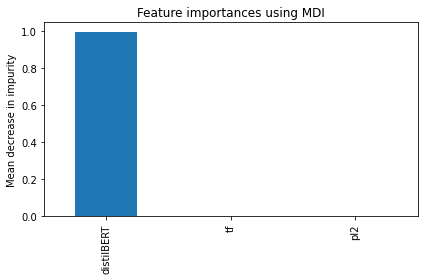

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

forest_importances = pd.Series(importances, index=["distilBERT", "tf", "pl2"])

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [ ]:
import time

start = time.time()

from sklearn.ensemble import RandomForestRegressor
rf_n = RandomForestRegressor(n_estimators=300)
pipe_no_distilBERT = L2R >> pt.ltr.apply_learned_model(rf_n)
pipe_no_distilBERT.fit(train_topics_100.head(100), train_qrel_100[:100])

end = time.time()

print(end - start)

18.624436616897583


In [ ]:
baseline = pt.Experiment([pipe_no_distilBERT], dataset.get_topics("test-2019"), dataset.get_qrels("test-2019"), filter_by_qrels = True, eval_metrics=["ndcg"], perquery = True)

In [ ]:
baseline.sort_values(by=['value'], ascending = True)

,name,qid,measure,value
32,"Compose(Compose(BR(BM25), FUnion(BR(Tf), BR(PL...",1121709,ndcg,0.000000
2,"Compose(Compose(BR(BM25), FUnion(BR(Tf), BR(PL...",1063750,ndcg,0.019697
31,"Compose(Compose(BR(BM25), FUnion(BR(Tf), BR(PL...",443396,ndcg,0.059568
4,"Compose(Compose(BR(BM25), FUnion(BR(Tf), BR(PL...",489204,ndcg,0.072466
13,"Compose(Compose(BR(BM25), FUnion(BR(Tf), BR(PL...",962179,ndcg,0.127609
8,"Compose(Compose(BR(BM25), FUnion(BR(Tf), BR(PL...",527433,ndcg,0.149103
16,"Compose(Compose(BR(BM25), FUnion(BR(Tf), BR(PL...",451602,ndcg,0.177251
19,"Compose(Compose(BR(BM25), FUnion(BR(Tf), BR(PL...",1112341,ndcg,0.189182
26,"Compose(Compose(BR(BM25), FUnion(BR(Tf), BR(PL...",1106007,ndcg,0.235539
1,"Compose(Compose(BR(BM25), FUnion(BR(Tf), BR(PL...",1110199,ndcg,0.240862


In [ ]:
pipe_no_distilBERT.search("definition declaratory judgment", qid = 130510)

,qid,docid,docno,score,query,features,rank
23,130510,8514425,8514425,0.420000,definition declaratory judgment,"[2.0, 14.176865332842267]",0
24,130510,8612904,8612904,0.420000,definition declaratory judgment,"[2.0, 14.176865332842267]",1
3,130510,7501563,7501563,0.150000,definition declaratory judgment,"[6.0, 19.50957901040532]",2
1,130510,7125239,7125239,0.130000,definition declaratory judgment,"[7.0, 20.14129940078319]",3
2,130510,799647,799647,0.006667,definition declaratory judgment,"[5.0, 19.653569861834313]",4
...,...,...,...,...,...,...,...
95,130510,7207412,7207412,0.000000,definition declaratory judgment,"[2.0, 10.805333954186697]",95
96,130510,7001677,7001677,0.000000,definition declaratory judgment,"[4.0, 10.69242157339265]",96
97,130510,1063368,1063368,0.000000,definition declaratory judgment,"[3.0, 10.47075157242548]",97
98,130510,4528808,4528808,0.000000,definition declaratory judgment,"[2.0, 10.350643362146549]",98


In [ ]:
pipe_no_distilBERT.search("why did the us volunterilay enter ww1", qid = '1063750')

,qid,docid,docno,score,query,features,rank
6,1063750,6093904,6093904,0.506667,why did the us volunterilay enter ww1,"[5.0, 12.427577793712105]",0
37,1063750,4762567,4762567,0.096777,why did the us volunterilay enter ww1,"[1.0, 10.217823893929749]",1
38,1063750,8378776,8378776,0.096777,why did the us volunterilay enter ww1,"[1.0, 10.217823893929749]",2
58,1063750,3208286,3208286,0.009000,why did the us volunterilay enter ww1,"[2.0, 9.508780512010278]",3
0,1063750,4788295,4788295,0.000000,why did the us volunterilay enter ww1,"[7.0, 14.982743309113086]",4
...,...,...,...,...,...,...,...
95,1063750,3057055,3057055,0.000000,why did the us volunterilay enter ww1,"[2.0, 8.631317808871652]",95
96,1063750,3934498,3934498,0.000000,why did the us volunterilay enter ww1,"[2.0, 8.631317808871652]",96
97,1063750,5236487,5236487,0.000000,why did the us volunterilay enter ww1,"[2.0, 8.631317808871652]",97
98,1063750,5236367,5236367,0.000000,why did the us volunterilay enter ww1,"[1.0, 8.48962284810477]",98


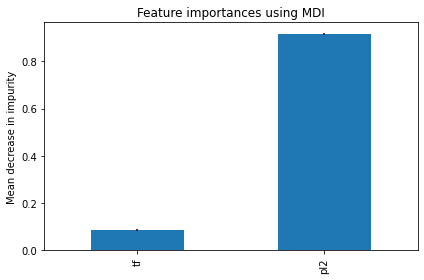

In [ ]:
importances = rf_n.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_n.estimators_], axis=0)

forest_importances = pd.Series(importances, index=["tf", "pl2"])

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [ ]:
!rm -rf Experiment

In [ ]:
!mkdir Experiment

In [ ]:
pt.Experiment([bm25, pipe_no_distilBERT, pipe_distilBERT, summation, BERT_alone], dataset.get_topics("test-2019"), dataset.get_qrels("test-2019"), filter_by_qrels = True, eval_metrics=["map", "ndcg", "recip_rank"], save_dir = "/content/Experiment", names = ["bm25", "L2R", "L2R+", "sum", "distilBERT"], baseline = 1)

,name,map,recip_rank,ndcg,map +,map -,map p-value,recip_rank +,recip_rank -,recip_rank p-value,ndcg +,ndcg -,ndcg p-value
0,bm25,0.290681,0.794961,0.445331,33.0,8.0,4.294484e-06,12.0,5.0,0.063467,31.0,11.0,5.291104e-05
1,L2R,0.216929,0.685004,0.393563,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,L2R+,0.271970,0.791871,0.445427,35.0,6.0,1.948901e-05,13.0,7.0,0.087498,34.0,8.0,3.571431e-04
3,sum,0.429484,0.884109,0.635663,43.0,0.0,2.338034e-14,17.0,2.0,0.001290,43.0,0.0,6.374761e-17
4,distilBERT,0.409712,0.976744,0.668718,37.0,6.0,2.302888e-06,18.0,1.0,0.000018,40.0,3.0,1.658538e-09


In [ ]:
results = pt.Experiment([bm25, pipe_no_distilBERT, pipe_distilBERT, summation, BERT_alone], dataset.get_topics("test-2019"), dataset.get_qrels("test-2019"), filter_by_qrels = True, eval_metrics=["map", "ndcg", "recip_rank"], save_dir = "/content/Experiment", names = ["bm25", "L2R", "L2R+", "sum", "distilBERT"], perquery = True)

In [ ]:
import pandas as pd
DOCS = pd.read_csv("/content/drive/MyDrive/collection.tar.gz", sep='\t', header=None, names=["docid","passage"])

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
results.astype({'value' : 'float'}).loc[(results['measure'] == 'ndcg') & (results['name'] == 'L2R+')].sort_values(by=['value'], ascending = False)

,name,qid,measure,value
362,L2R+,855410,ndcg,0.895972
269,L2R+,130510,ndcg,0.882416
296,L2R+,1121402,ndcg,0.786778
377,L2R+,182539,ndcg,0.773967
365,L2R+,1114646,ndcg,0.713166
386,L2R+,146187,ndcg,0.712842
341,L2R+,1124210,ndcg,0.702513
350,L2R+,87181,ndcg,0.696663
260,L2R+,156493,ndcg,0.689851
344,L2R+,490595,ndcg,0.673065


In [ ]:
pipe_distilBERT.search("definition declaratory judgment", qid = 130510)

,qid,docid,docno,score,query,features,rank
0,130510,1494936,1494936,0.366667,definition declaratory judgment,"[0.8415981531143188, 6.0, 20.265028455560408]",0
13,130510,8612903,8612903,0.320000,definition declaratory judgment,"[0.8134920001029968, 3.0, 16.24377413170329]",1
12,130510,8612909,8612909,0.260000,definition declaratory judgment,"[0.8359456062316895, 2.0, 16.592056692245794]",2
17,130510,8612902,8612902,0.160000,definition declaratory judgment,"[0.650006115436554, 2.0, 15.672960483375881]",3
14,130510,8612910,8612910,0.146667,definition declaratory judgment,"[0.8511649370193481, 2.0, 16.26917520354018]",4
...,...,...,...,...,...,...,...
95,130510,7207412,7207412,0.000000,definition declaratory judgment,"[0.0, 2.0, 10.805333954186697]",95
96,130510,7001677,7001677,0.000000,definition declaratory judgment,"[0.0, 4.0, 10.69242157339265]",96
97,130510,1063368,1063368,0.000000,definition declaratory judgment,"[0.3740402460098266, 3.0, 10.47075157242548]",97
98,130510,4528808,4528808,0.000000,definition declaratory judgment,"[0.5605348944664001, 2.0, 10.350643362146549]",98


In [ ]:
pipe_distilBERT.search("why did the us volunterilay enter ww1", qid = '1063750')

,qid,docid,docno,score,query,features,rank
2,1063750,4337527,4337527,0.006667,why did the us volunterilay enter ww1,"[0.6330872774124146, 3.0, 14.811733488157689]",0
0,1063750,4788295,4788295,0.000000,why did the us volunterilay enter ww1,"[0.5321999788284302, 7.0, 14.982743309113086]",1
1,1063750,2997653,2997653,0.000000,why did the us volunterilay enter ww1,"[0.415865033864975, 6.0, 14.65359324445613]",2
3,1063750,6093907,6093907,0.000000,why did the us volunterilay enter ww1,"[0.4464205503463745, 4.0, 13.565743245806374]",3
4,1063750,2981566,2981566,0.000000,why did the us volunterilay enter ww1,"[0.0, 3.0, 13.084359683460981]",4
...,...,...,...,...,...,...,...
95,1063750,3057055,3057055,0.000000,why did the us volunterilay enter ww1,"[0.0, 2.0, 8.631317808871652]",95
96,1063750,3934498,3934498,0.000000,why did the us volunterilay enter ww1,"[0.0, 2.0, 8.631317808871652]",96
97,1063750,5236487,5236487,0.000000,why did the us volunterilay enter ww1,"[0.0, 2.0, 8.631317808871652]",97
98,1063750,5236367,5236367,0.000000,why did the us volunterilay enter ww1,"[0.0, 1.0, 8.48962284810477]",98


In [ ]:
results.astype({'value' : 'float'}).loc[(results['measure'] == 'ndcg') & (results['name'] == 'sum')].sort_values(by=['value'], ascending = False)

,name,qid,measure,value
491,sum,855410,ndcg,0.990661
389,sum,156493,ndcg,0.943200
407,sum,168216,ndcg,0.922705
470,sum,1124210,ndcg,0.893874
425,sum,1121402,ndcg,0.879789
398,sum,130510,ndcg,0.878387
440,sum,359349,ndcg,0.873024
506,sum,182539,ndcg,0.855319
479,sum,87181,ndcg,0.843445
515,sum,146187,ndcg,0.841586


In [ ]:
summation.search("definition declaratory judgment", qid = 130510)

,qid,docid,docno,score,query,rank
0,130510,1494936,1494936,49.582221,definition declaratory judgment,0
2,130510,799647,799647,47.966123,definition declaratory judgment,1
6,130510,8612906,8612906,45.823094,definition declaratory judgment,2
1,130510,7125239,7125239,45.773692,definition declaratory judgment,3
3,130510,7501563,7501563,45.657303,definition declaratory judgment,4
...,...,...,...,...,...,...
993,130510,8330073,8330073,16.204603,definition declaratory judgment,995
994,130510,6162829,6162829,16.203673,definition declaratory judgment,996
995,130510,7738711,7738711,16.203673,definition declaratory judgment,997
996,130510,691377,691377,16.199872,definition declaratory judgment,998


In [ ]:
summation.search("why did the us volunterilay enter ww1", qid = '1063750')

,qid,docid,docno,score,query,rank
2,1063750,4337527,4337527,35.895364,why did the us volunterilay enter ww1,0
0,1063750,4788295,4788295,35.662022,why did the us volunterilay enter ww1,1
1,1063750,2997653,2997653,33.954442,why did the us volunterilay enter ww1,2
3,1063750,6093907,6093907,32.140440,why did the us volunterilay enter ww1,3
8,1063750,4337526,4337526,31.322823,why did the us volunterilay enter ww1,4
...,...,...,...,...,...,...
995,1063750,2690513,2690513,10.536260,why did the us volunterilay enter ww1,995
996,1063750,2934779,2934779,10.536260,why did the us volunterilay enter ww1,996
997,1063750,2975519,2975519,10.536260,why did the us volunterilay enter ww1,997
998,1063750,3109770,3109770,10.536260,why did the us volunterilay enter ww1,998


In [ ]:
results.astype({'value' : 'float'}).loc[(results['measure'] == 'ndcg') & (results['name'] == 'distilBERT')].sort_values(by=['value'], ascending = False)

,name,qid,measure,value
554,distilBERT,1121402,ndcg,0.940146
620,distilBERT,855410,ndcg,0.934916
551,distilBERT,264014,ndcg,0.906895
557,distilBERT,962179,ndcg,0.904039
518,distilBERT,156493,ndcg,0.897833
527,distilBERT,130510,ndcg,0.875675
539,distilBERT,1133167,ndcg,0.865303
584,distilBERT,833860,ndcg,0.854301
533,distilBERT,573724,ndcg,0.842494
569,distilBERT,359349,ndcg,0.841290


In [ ]:
BERT_alone.search("definition declaratory judgment", qid = '130510')

,qid,query,docno,score,rank
0,130510,definition declaratory judgment,8612910,0.8511649370193481,0
1,130510,definition declaratory judgment,1494936,0.8415981531143188,1
10,130510,definition declaratory judgment,8612902,0.650006115436554,10
100,130510,definition declaratory judgment,783660,0.4465055167675018,100
101,130510,definition declaratory judgment,3783876,0.4459144175052643,101
...,...,...,...,...,...
995,130510,definition declaratory judgment,5470336,0.3383256494998932,995
996,130510,definition declaratory judgment,365977,0.3382940292358398,996
997,130510,definition declaratory judgment,5008765,0.3382642269134521,997
998,130510,definition declaratory judgment,359228,0.3382479548454284,998


In [ ]:
BERT_alone.search("why did the us volunterilay enter ww1", qid = '1063750')

,qid,query,docno,score,rank
0,1063750,why did the us volunterilay enter ww1,4337532,0.6715980768203735,0
1,1063750,why did the us volunterilay enter ww1,2230089,0.6433300971984863,1
10,1063750,why did the us volunterilay enter ww1,7952964,0.6207059621810913,10
100,1063750,why did the us volunterilay enter ww1,1580966,0.4974569082260132,100
101,1063750,why did the us volunterilay enter ww1,25201,0.4973031282424927,101
...,...,...,...,...,...
995,1063750,why did the us volunterilay enter ww1,4980368,0.3897849917411804,995
996,1063750,why did the us volunterilay enter ww1,8170637,0.3897374272346496,996
997,1063750,why did the us volunterilay enter ww1,2267913,0.3897242546081543,997
998,1063750,why did the us volunterilay enter ww1,5585985,0.3897057175636291,998


In [ ]:
results.astype({'value' : 'float'}).loc[(results['measure'] == 'ndcg') & (results['name'] == 'bm25')].sort_values(by=['value'], ascending = False)

,name,qid,measure,value
104,bm25,855410,ndcg,0.881199
119,bm25,182539,ndcg,0.826885
11,bm25,130510,ndcg,0.815052
38,bm25,1121402,ndcg,0.790746
128,bm25,146187,ndcg,0.759258
83,bm25,1124210,ndcg,0.724603
53,bm25,359349,ndcg,0.713280
2,bm25,156493,ndcg,0.710167
62,bm25,131843,ndcg,0.675737
92,bm25,87181,ndcg,0.642155


In [ ]:
bm25.search("definition declaratory judgment", qid = 130510)

,qid,docid,docno,rank,score,query
0,130510,1494936,1494936,0,41.166240,definition declaratory judgment
1,130510,7125239,7125239,1,40.377558,definition declaratory judgment
2,130510,799647,799647,2,39.952422,definition declaratory judgment
3,130510,7501563,7501563,3,39.800835,definition declaratory judgment
4,130510,996732,996732,4,39.395265,definition declaratory judgment
...,...,...,...,...,...,...
95,130510,7207412,7207412,95,21.637560,definition declaratory judgment
96,130510,7001677,7001677,96,21.615254,definition declaratory judgment
97,130510,1063368,1063368,97,21.417019,definition declaratory judgment
98,130510,4528808,4528808,98,21.375249,definition declaratory judgment


In [ ]:
bm25.search("why did the us volunterilay enter ww1", qid = 1063750)

,qid,docid,docno,rank,score,query
0,1063750,4788295,4788295,0,30.340022,why did the us volunterilay enter ww1
1,1063750,2997653,2997653,1,29.795791,why did the us volunterilay enter ww1
2,1063750,4337527,4337527,2,29.564491,why did the us volunterilay enter ww1
3,1063750,6093907,6093907,3,27.676235,why did the us volunterilay enter ww1
4,1063750,2981566,2981566,4,27.031930,why did the us volunterilay enter ww1
...,...,...,...,...,...,...
95,1063750,3057055,3057055,95,17.684808,why did the us volunterilay enter ww1
96,1063750,3934498,3934498,96,17.684808,why did the us volunterilay enter ww1
97,1063750,5236487,5236487,97,17.684808,why did the us volunterilay enter ww1
98,1063750,5236367,5236367,98,17.564583,why did the us volunterilay enter ww1
